# GANs - Generative Adverserial Networks

**In this project, I aimed to create fake images using GAN architecture. I used the number images of all zero's in MINST dataset which exists in Keras' built-in datasets**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()

**Reshape and Rescale Images**

In [4]:
X_train = X_train/255

In [5]:
# Generator uses tanh activation function for the last layer, so we want to reshape X_train to be within -1 to 1 limits.
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

**Filter out the Data for Faster Training on Smaller Dataset (Work with only Zero's)**

In [6]:
only_zeros = X_train[y_train==0]

In [7]:
only_zeros.shape

(5923, 28, 28, 1)

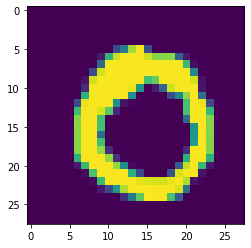

In [8]:
plt.imshow(only_zeros[5])

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Sequential

**Generator**

In [10]:
codings_size = 100

In [11]:
# Generator is like the "decoder" part of Autoencoder
generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape=[codings_size]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"))

**Discriminator**

In [12]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1,activation="sigmoid")) # It is binary classification - Is this image real or fake?

discriminator.compile(loss="binary_crossentropy", optimizer="adam")

In [13]:
GAN = Sequential([generator, discriminator])

In [14]:
discriminator.trainable = False # Since discriminator shouldn't be trained in second phase

In [15]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [16]:
# Generator Model
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
________________________________________________

In [17]:
# Discriminator Model
GAN.layers[1].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 0
Non-trainable params: 212,865
________________________________________________

**Create Training Batches**

In [18]:
batch_size = 32

In [19]:
my_data = only_zeros

In [20]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [21]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [22]:
epochs = 20

**Training Loop**

In [23]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For each epoch
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
                    
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0) # TO use tf.concat, the data types must match!
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")            

Currently on Epoch 1
Currently on Epoch 2
Currently on Epoch 3
Currently on Epoch 4
Currently on Epoch 5
Currently on Epoch 6
Currently on Epoch 7
Currently on Epoch 8
Currently on Epoch 9
Currently on Epoch 10
Currently on Epoch 11
Currently on Epoch 12
Currently on Epoch 13
Currently on Epoch 14
Currently on Epoch 15
Currently on Epoch 16
Currently on Epoch 17
Currently on Epoch 18
Currently on Epoch 19
Currently on Epoch 20
TRAINING COMPLETE


**Generate Fake Images**

In [24]:
noise = tf.random.normal(shape=[10, codings_size])

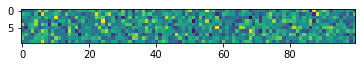

In [25]:
plt.imshow(noise)

In [26]:
# Apply noise
images = generator(noise)

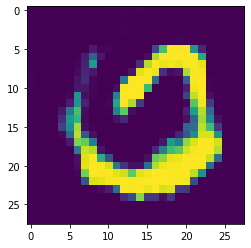

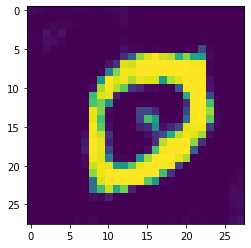

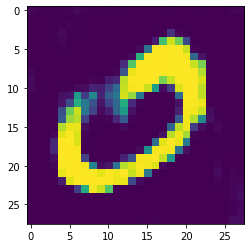

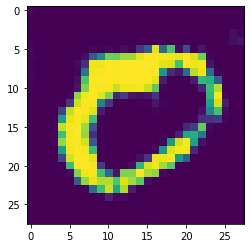

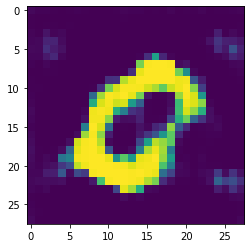

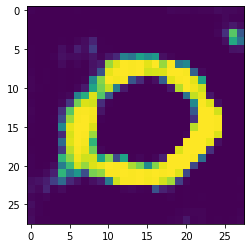

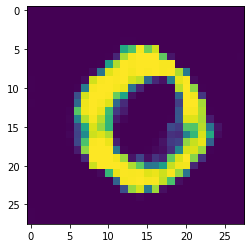

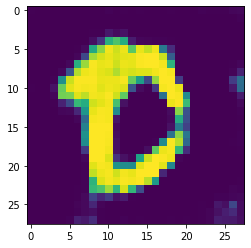

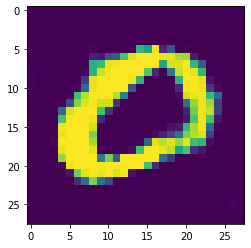

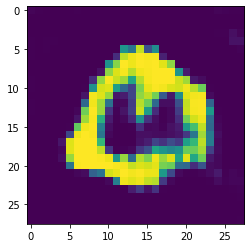

In [27]:
# Show the images
for image in images:
    plt.imshow(image.numpy().reshape(28,28))
    plt.show()